# Spotify music analysis

This notebook does basic analysis of song metadata taken from spotify. The data contains numeric metrics generated by spotify which measure the songs' danceability, mood, liveness, etc. The data also contains the songs' title and artist.

First we import all the necessary modules and generate the table to analyse.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn import datasets, linear_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

%matplotlib inline

data_frame = pd.read_csv("../input/data.csv")
data_frame = data_frame.drop("Unnamed: 0", axis="columns")
data_frame.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Mask Off,Future
1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Redbone,Childish Gambino
2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Xanny Family,Future
3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Master Of None,Beach House
4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Parallel Lines,Junior Boys


For our first trick we'll create a scatterplot based on the songs' valence and danceability values. In addition, we will also use linear regression to find their correlation.

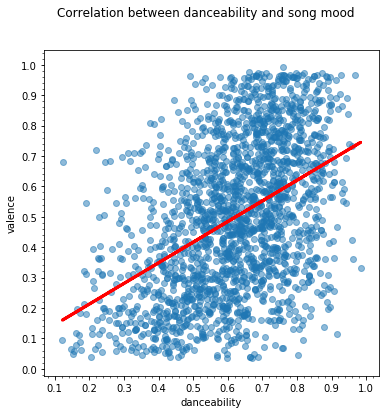

In [2]:
x = data_frame["danceability"].values
y = data_frame["valence"].values

x = x.reshape(x.shape[0], 1)
y = y.reshape(y.shape[0], 1)

regr = linear_model.LinearRegression()
regr.fit(x, y)

fig = plt.figure(figsize=(6, 6))
fig.suptitle("Correlation between danceability and song mood")

ax = plt.subplot(1, 1, 1)
ax.scatter(x, y, alpha=0.5)
ax.plot(x, regr.predict(x), color="red", linewidth=3)
plt.xticks(())
plt.yticks(())

ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.02))

ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.02))

plt.xlabel("danceability")
plt.ylabel("valence")

plt.show()

Now to create some histograms. The plot on the left illustrates the distribution of songs based on their energy levels, whereas the one on the right is a "heatmap" (histogram in two dimensions) that illustrates the number of songs found at all values of valence and danceability.

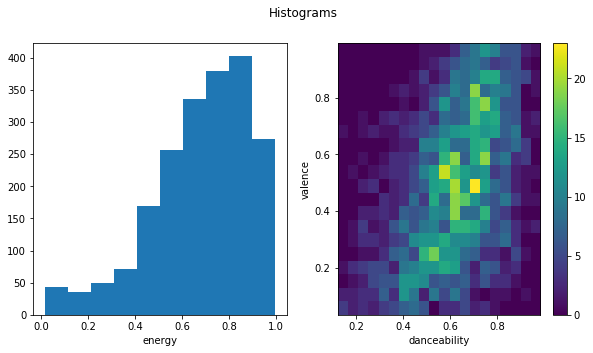

In [3]:
x = "danceability"
y = "valence"

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, sharex=False, figsize=(10, 5))
fig.suptitle("Histograms")
h = ax2.hist2d(data_frame[x], data_frame[y], bins=20)
ax1.hist(data_frame["energy"])

ax2.set_xlabel(x)
ax2.set_ylabel(y)

ax1.set_xlabel("energy")

plt.colorbar(h[3], ax=ax2)

plt.show()

# This is where the fun begins
Next, we generate a list of "chosen" traits and use principal component analysis to reduce the dimensions of that list to 3, effectively creating a matrix suitable for generating the following 3-dimensional plot. The lesser the distance between any two songs, the larger the similarities in their traits.

In [4]:
chosen = ["energy", "liveness", "tempo", "valence", "loudness", "speechiness", "acousticness", "danceability", "instrumentalness"]
text1 = data_frame["artist"] + " - " + data_frame["song_title"]
text2 = text1.values

# X = data_frame.drop(droppable, axis=1).values
X = data_frame[chosen].values
y = data_frame["danceability"].values

min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(X)

pca = PCA(n_components=3)
pca.fit(X)

X = pca.transform(X)

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

trace = go.Scatter3d(
    x=X[:,0],
    y=X[:,1],
    z=X[:,2],
    text=text2,
    mode="markers",
    marker=dict(
        size=8,
        color=y
    )
)

fig = go.Figure(data=[trace])
py.iplot(fig, filename="test-graph")

In another attempt, we use a smaller "chosen" list and PCA to generate a two-dimensional graph.This specific graph was chosen due to its seemingly spot-on axes naming.

In [5]:
chosen = ["energy", "liveness", "tempo", "valence"]
text1 = data_frame["artist"] + " - " + data_frame["song_title"]
text2 = text1.values

# X = data_frame.drop(droppable, axis=1).values
X = data_frame[chosen].values
y = data_frame["loudness"].values

min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(X)

pca = PCA(n_components=2)
pca.fit(X)

X = pca.transform(X)

fig = {
    "data": [
        {
            "x": X[:, 0],
            "y": X[:, 1],
            "text": text2,
            "mode": "markers",
            "marker": {"size": "8", "color": y}
        }
    ],
    "layout": {
        "xaxis": {"title": "How hard is this to dance to?"},
        "yaxis": {"title": "How metal is this?"}
    }
}

py.iplot(fig, filename="test-graph2")

Last but not least we generate a similar graph using t-SNE and yet another "chosen" list instead.

In [6]:
import time

chosen = ["energy", "liveness", "tempo", "valence", "loudness",
          "speechiness", "acousticness", "danceability", "instrumentalness"]

X = data_frame[chosen].values
y = data_frame["loudness"].values

min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(X)

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

fig = {
    "data": [
        {
            "x": tsne_results[:, 0],
            "y": tsne_results[:, 1],
            "text": text2,
            "mode": "markers",
            "marker": {"size": "8", "color": y}
        }
    ],
    "layout": {
        "xaxis": {"title": "x-tsne"},
        "yaxis": {"title": "y-tsne"}
    }
}

py.iplot(fig, filename="test-graph2")

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2017 samples in 0.002s...
[t-SNE] Computed neighbors for 2017 samples in 0.155s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2017
[t-SNE] Computed conditional probabilities for sample 2000 / 2017
[t-SNE] Computed conditional probabilities for sample 2017 / 2017
[t-SNE] Mean sigma: 0.145413
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.526894
[t-SNE] Error after 300 iterations: 1.485660
t-SNE done! Time elapsed: 16.126283168792725 seconds
